In [353]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

In [4]:

data = np.load('proyecto_training_data.npy')
column_names = ["SalePrice","OverallQual","1stFlrSF","TotRmsAbrGrd","YearBuilt","LotFrontage"]
data_df = pd.DataFrame(data, columns=column_names)
#data_df.to_excel('output.xlsx')


In [5]:
data_df.isnull().sum()

SalePrice         0
OverallQual       0
1stFlrSF          0
TotRmsAbrGrd      0
YearBuilt         0
LotFrontage     259
dtype: int64

In [6]:
#replacing null values with average
data[np.isnan(data)] = int(np.nanmean(data[:,5]))
data_df.isnull().sum()


SalePrice       0
OverallQual     0
1stFlrSF        0
TotRmsAbrGrd    0
YearBuilt       0
LotFrontage     0
dtype: int64

In [7]:
rows, columns = data.shape
training_set = data[:int(rows*0.8)]
test_set = data[int(rows*0.8):]
training_pd = pd.DataFrame(training_set, columns=column_names)
test_pd = pd.DataFrame(test_set, columns=column_names)
training_pd, test_pd

(      SalePrice  OverallQual  1stFlrSF  TotRmsAbrGrd  YearBuilt  LotFrontage
 0      208500.0          7.0     856.0           8.0     2003.0         65.0
 1      181500.0          6.0    1262.0           6.0     1976.0         80.0
 2      223500.0          7.0     920.0           6.0     2001.0         68.0
 3      140000.0          7.0     961.0           7.0     1915.0         60.0
 4      250000.0          8.0    1145.0           9.0     2000.0         84.0
 ...         ...          ...       ...           ...        ...          ...
 1163   108959.0          4.0    1258.0           6.0     1969.0         60.0
 1164   194000.0          5.0    1432.0           5.0     1978.0         70.0
 1165   233170.0          7.0    1502.0           7.0     2009.0         79.0
 1166   245350.0          8.0    1694.0           7.0     2008.0         64.0
 1167   173000.0          6.0     959.0           7.0     2000.0         58.0
 
 [1168 rows x 6 columns],
      SalePrice  OverallQual  1stFlr

In [8]:
training_pd.describe()

,SalePrice,OverallQual,1stFlrSF,TotRmsAbrGrd,YearBuilt,LotFrontage
count,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,180590.277397,6.101027,1156.323630,6.485445,1971.451199,69.956336
std,78815.697902,1.378025,373.780374,1.609141,29.951707,21.305441
min,34900.000000,1.000000,334.000000,2.000000,1875.000000,21.000000
25%,129900.000000,5.000000,882.000000,5.000000,1954.000000,60.000000
50%,162950.000000,6.000000,1086.000000,6.000000,1973.000000,70.000000
75%,214000.000000,7.000000,1390.250000,7.000000,2000.000000,79.000000
max,755000.000000,10.000000,3228.000000,14.000000,2010.000000,313.000000


In [9]:
#peak to peak
pd.DataFrame(np.ptp(training_set,axis=0).reshape(1,columns),columns=column_names)

,SalePrice,OverallQual,1stFlrSF,TotRmsAbrGrd,YearBuilt,LotFrontage
0,720100.0,9.0,2894.0,12.0,135.0,292.0


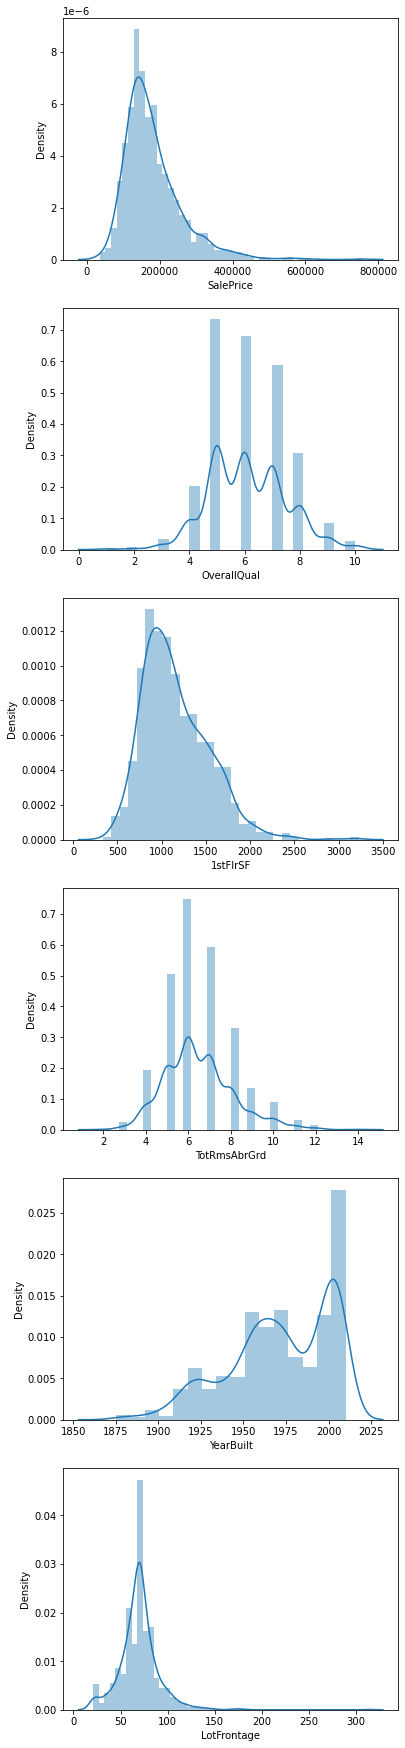

In [10]:
fig, axs = plt.subplots(nrows=columns)

for i,column_name in enumerate(column_names):
    sns.distplot(training_set[:,i],kde=True,ax=axs[i],axlabel=column_name)
plt.subplots_adjust(top=6)
plt.show()

**Correlacion de Variables independientes:**

In [11]:
correlacion = np.corrcoef(training_set,rowvar=False)[0,:]
pd.DataFrame(correlacion[1:].reshape(1,5),columns=column_names[1:])

,OverallQual,1stFlrSF,TotRmsAbrGrd,YearBuilt,LotFrontage
0,0.79399,0.616289,0.564707,0.534171,0.348549


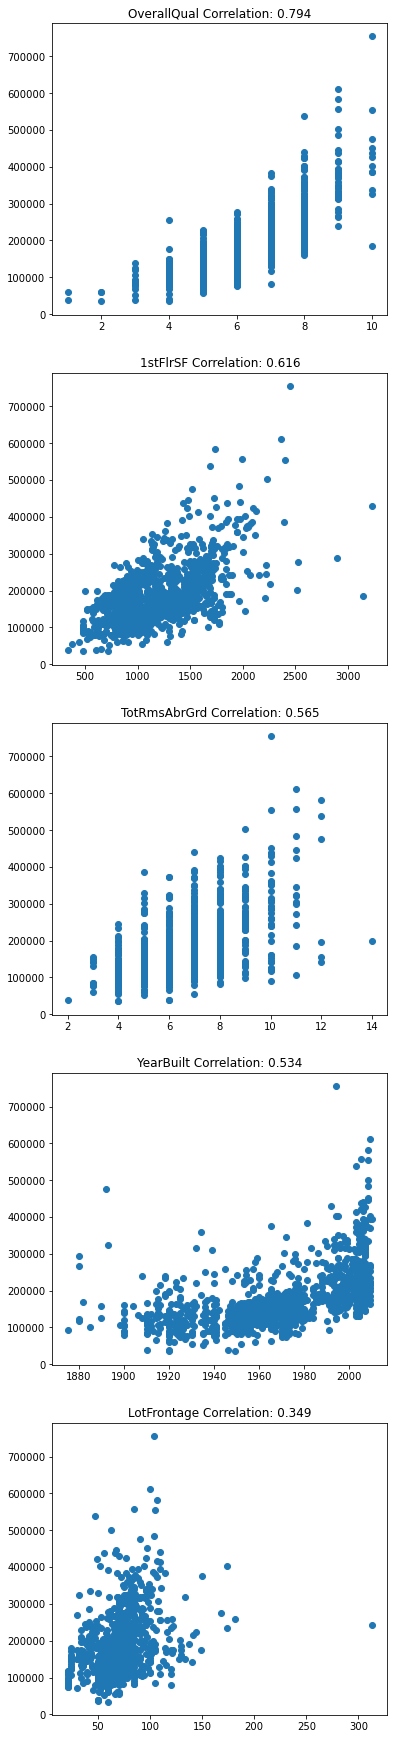

In [308]:
fig, axs = plt.subplots(nrows=columns-1)

for i,column_name in enumerate(column_names[1:]):
    axs[i].scatter(training_set[:,i+1],training_set[:,0])
    axs[i].title.set_text(column_name + " Correlation: " + str(np.round(correlacion[i+1],3)))
plt.subplots_adjust(top=6)
plt.show()

**Las Variables con mayor potencial predictivo son: **
* OverallQual
* 1stFlrSF


In [338]:
def print_error(iteracion,error):
    print("Error Iteracion " + str(iteracion) + ": " + str(error))

def training_model(x, y, epochs, imprimir_error_cada, lr):
    matriz = np.hstack((x.reshape(x.size,1),np.ones((x.size,1))))
    parametros = np.array([0,0])    #parametro_m, parametro_b
    modelos = {}
    errores = [] #cada elemento representa error en iteracion numero i+1
    for iteracion in range(1,epochs+1):
        yhat = np.matmul(matriz,parametros)
        error = np.mean(np.power(y-yhat,2))/2
        errores.append(error)
        modelos[iteracion] = parametros
        gradientes = np.matmul((yhat-y),matriz)/x.size    #elemento 0 = gradiente_m, elemento 1 = gradiente_b
        #print(iteracion, error, parametros, gradientes)
        parametros = parametros-lr*gradientes
        
        if iteracion%imprimir_error_cada==0:
            print_error(iteracion,error)
            
    return modelos, errores

def plot_error(errores):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(errores)
    ax.set_title('Loss')
    plt.show()

def plot_model(modelos,n,x):
    for i in modelos:
        if i%n==0:
            m, b = modelos.get(i)
            yhat = m*x+b
            fig = plt.figure()
            ax = fig.add_subplot(1,1,1)
            ax.scatter(x,y,color='black')
            ax.plot(x,yhat,color='red')
            ax.set_title('y = ' + str(round(m,3)) + 'x + ' + str(round(b,3)))
            plt.show()


Error Iteracion 15: 1391513812.4658084


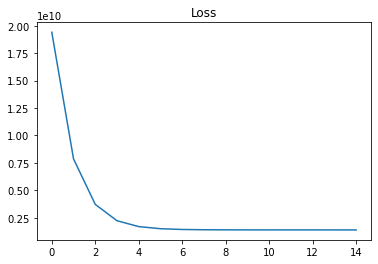

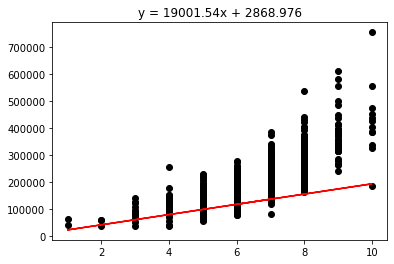

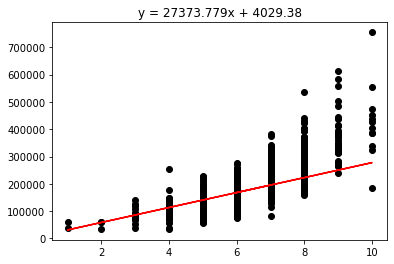

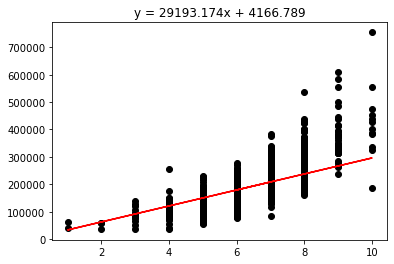

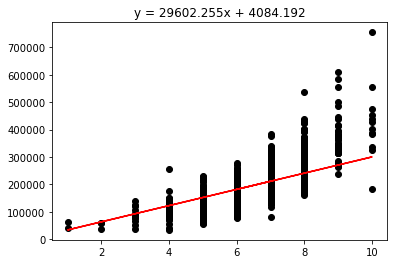

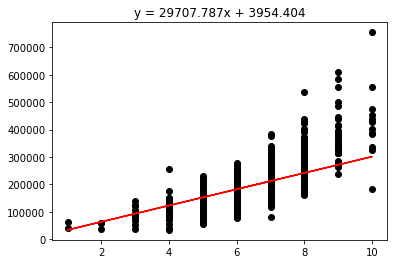

In [366]:
x = training_set[:,1]
y = training_set[:,0]

modelos, errores = training_model(training_set[:,1],training_set[:,0],15,15,0.01)
plot_error(errores)
plot_model(modelos,3,x)
modelo_manual_OverallQual = modelos.get(len(modelos.keys()))

Error Iteracion 15: 19208675210.162865


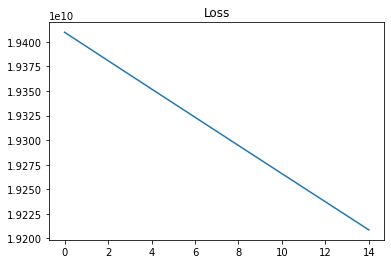

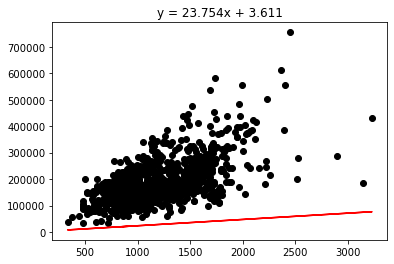

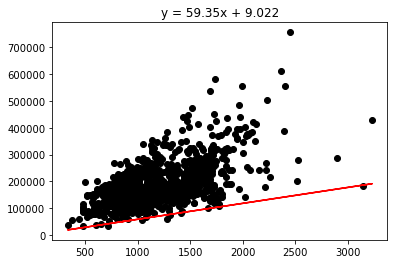

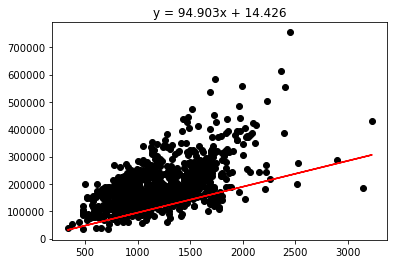

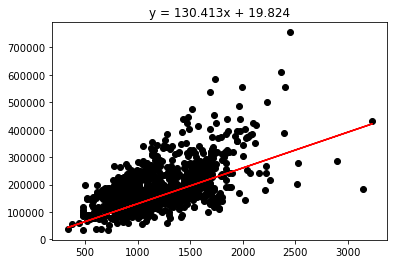

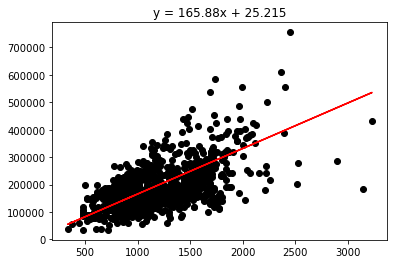

In [365]:
x = training_set[:,2]
y = training_set[:,0]

modelos, errores = training_model(training_set[:,1],training_set[:,0],15,15,0.00001)
plot_error(errores)
plot_model(modelos,3,x)
modelo_manual_1stFlrSF = modelos.get(len(modelos.keys()))


In [368]:
x1 = training_set[:,1].reshape(-1,1)
x2 = training_set[:,2].reshape(-1,1)
y = training_set[:,0].reshape(-1,1)
modelo_sklearn_OverallQual = LinearRegression().fit(x1,y)
modelo_sklearn_1stFlrSF = LinearRegression().fit(x2,y)
print(modelo_sklearn_OverallQual.coef_,modelo_sklearn_OverallQual.intercept_)
print(modelo_sklearn_1stFlrSF.coef_,modelo_sklearn_1stFlrSF.intercept_)

[[45411.99877916]] [-96469.57131874]
[[129.95124229]] [30324.58517496]


In [376]:
def predict_model(manual_model, sklearn_model, x):
    yhat_sk = sklearn_model.predict(x)
    yhat_manual = manual_model[0]*x + manual_model[1]
    yhat_mean = (yhat_manual + yhat_sk)/2
    return yhat_manual, yhat_sk, yhat_mean

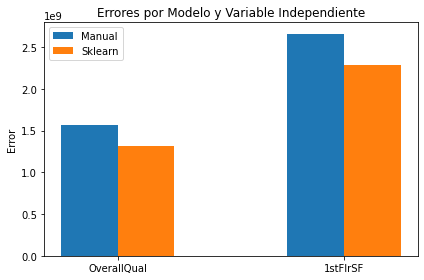

In [418]:
x1 = test_set[:,1].reshape(-1,1)
x2 = test_set[:,2].reshape(-1,1)
y = test_set[:,0].reshape(-1,1)

yhat_manual_x1, yhat_sklearn_x1, yhat_mean_x1 = predict_model(modelo_manual_OverallQual, modelo_sklearn_OverallQual, x1)
yhat_manual_x2, yhat_sklearn_x2, yhat_mean_x2 = predict_model(modelo_manual_1stFlrSF, modelo_sklearn_1stFlrSF, x2)

error_manual_x1 = (np.mean(np.power((y-yhat_manual_x1),2)))/2
error_sklearn_x1 = (np.mean(np.power((y-yhat_sklearn_x1),2)))/2
error_avg_x1 = (np.mean(np.power((y-yhat_mean_x1),2)))/2

error_manual_x2 = (np.mean(np.power((y-yhat_manual_x2),2)))/2
error_sklearn_x2 = (np.mean(np.power((y-yhat_sklearn_x2),2)))/2
error_avg_x2 = (np.mean(np.power((y-yhat_mean_x2),2)))/2

labels = ['OverallQual','1stFlrSF']
x = np.arange(len(labels))
width = 0.25
errores_manual = [error_manual_x1,error_manual_x2]
errores_sklearn = [error_sklearn_x1,error_sklearn_x2]

fig, ax = plt.subplots()
rect1 = ax.bar(x - width/2, errores_manual, width, label='Manual')
rect2 = ax.bar(x + width/2, errores_sklearn, width, label='Sklearn')

ax.set_ylabel('Error')
ax.set_title('Errores por Modelo y Variable Independiente')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()


